## 004 LSTM in Trading

- Antonio Lomelí Ureña
- Carolina Martínez Escalante
- Enrique Tonatiuh Pérez Cortés Barba

### Objective:
Explore the application of Long Short-Term Memory (LSTM) neural networks in the analysis and prediction of financial time series, specifically oriented towards trading.

### 1- Data Preparation and Model Development

In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import joblib
from tensorflow.keras.models import load_model
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')

import seaborn as sns
sns.set()

[*********************100%***********************]  1 of 1 completed


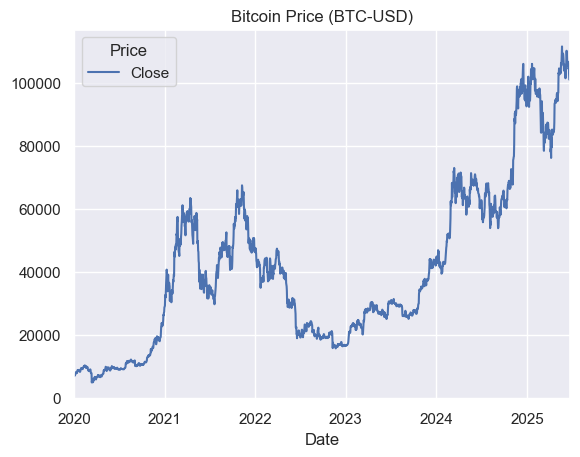

In [2]:
# DOWNLOAD DATA
# Download historical daily price data for Bitcoin (BTC-USD) from Yahoo Finance
data = yf.download('BTC-USD', start='2020-01-01', end='2025-06-25')
data.columns = data.columns.droplevel(1)

data = data[['Close']]
data.plot()
plt.title('Bitcoin Price (BTC-USD)')

np.random.seed(42)

In [3]:
# NORMALIZE DATA
# This section scales the closing price data to a range between 0 and 1 using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data)

In [4]:
# CREATE SEQUENCES
# This function creates input-output pairs for time series prediction.
def create_dataset(data, time_steps=60):
    X, y = [], []
    for i in range(time_steps, len(data)):
        X.append(data[i-time_steps:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

# Generate sequences
X, y = create_dataset(scaled_data)

# Resize X to be LSTM compatible
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

In [5]:
# SPLIT DATA
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=False)
X_train.shape

(1359, 60, 1)

In [6]:
# Create Early Stopping callback
early_stop = EarlyStopping(
    monitor='val_loss',    # Loss metric to monitor
    patience=10,            
    restore_best_weights=True
                )

In [7]:
# BUILD LSTM MODEL
model = Sequential()

# Input layer
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
# Hidden layers
model.add(LSTM(units=30, return_sequences=True))
model.add(Dropout(0.2)) # A dropout lower than 0.3 is used to prevent excessive information loss, which could harm training

model.add(LSTM(units=20))
model.add(Dropout(0.2))

# Output layer (Dense). Predicts the next day's price
model.add(Dense(units=1))


In [8]:
# Compile and Summarize the Model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 60, 30)         │         9,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 60, 30)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 20)             │         4,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,221 (94.61 KB)

 Trainable params: 24,221 (94.61 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# TRAIN AND PREDICT
model.fit(X_train, y_train, 
          epochs=100, 
          batch_size=20, 
          validation_data=(X_test, y_test),
          callbacks=[early_stop],)

Epoch 1/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - loss: 0.0111 - mae: 0.0755 - val_loss: 0.0170 - val_mae: 0.1134
Epoch 2/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0027 - mae: 0.0363 - val_loss: 0.0133 - val_mae: 0.0947
Epoch 3/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0026 - mae: 0.0350 - val_loss: 0.0089 - val_mae: 0.0773
Epoch 4/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0019 - mae: 0.0311 - val_loss: 0.0080 - val_mae: 0.0717
Epoch 5/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0018 - mae: 0.0300 - val_loss: 0.0035 - val_mae: 0.0455
Epoch 6/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0016 - mae: 0.0284 - val_loss: 0.0100 - val_mae: 0.0839
Epoch 7/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0016 - mae: 0.0273 - val_loss: 0.0034 - val_mae: 0.0451
Epoch 8/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0017 - mae: 0.0286 - val_loss: 0.0076 - val_mae: 0.0712
Epoch 9/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - lo

In [10]:
# Get the metrics for the test set
loss, mae = model.evaluate(X_test, y_test, verbose=1)
print(f"Test MAE: {mae:.4f}")

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0010 - mae: 0.0239    
Test MAE: 0.0310


In [11]:
# Predict using the trained model
y_pred = model.predict(X_test)
# Reshape the predictions to 2D (required by inverse_transform)
# Inverse transform to get the predictions back to original price scale
y_pred = y_pred.reshape(-1, 1)
y_pred = scaler.inverse_transform(y_pred).flatten()

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step


In [12]:
# Inverse transform the test target values to return them to their original price scale
y_test = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

In [13]:
y_test[:10] # First ten predicted values in the test set

array([37476.95703125, 35813.8125    , 37432.33984375, 37289.62109375,
       37720.28125   , 37796.79296875, 37479.12109375, 37254.16796875,
       37831.0859375 , 37858.4921875 ])

In [14]:
# Display some predicted vs actual price values
print("Predictions vs Actual Prices")
for i in range(100):
    print(f"Prediction {i+1}: {y_pred[i]}, Actual Price: {y_test[i]}")

Predictions vs Actual Prices
Prediction 1: 37039.88671875, Actual Price: 37476.95703125
Prediction 2: 37102.9296875, Actual Price: 35813.8125
Prediction 3: 37131.81640625, Actual Price: 37432.33984375
Prediction 4: 37158.22265625, Actual Price: 37289.62109375
Prediction 5: 37191.14453125, Actual Price: 37720.28125
Prediction 6: 37246.03515625, Actual Price: 37796.79296875
Prediction 7: 37327.3515625, Actual Price: 37479.12109375
Prediction 8: 37421.609375, Actual Price: 37254.16796875
Prediction 9: 37511.265625, Actual Price: 37831.0859375
Prediction 10: 37602.79296875, Actual Price: 37858.4921875
Prediction 11: 37696.69140625, Actual Price: 37712.74609375
Prediction 12: 37786.171875, Actual Price: 38688.75
Prediction 13: 37894.82421875, Actual Price: 39476.33203125
Prediction 14: 38050.2578125, Actual Price: 39978.390625
Prediction 15: 38268.6328125, Actual Price: 41980.09765625
Prediction 16: 38600.7734375, Actual Price: 44080.6484375
Prediction 17: 39105.28515625, Actual Price: 4374

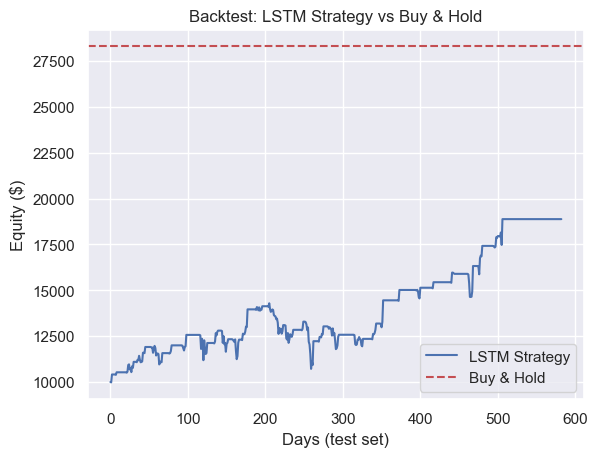

Final equity LSTM strategy: $18878.87
Buy & Hold equity: $28296.22
Return LSTM strategy: 88.79%
Return Buy & Hold: 182.96%


In [69]:
# BACKTESTING
# If tomorrow's predicted price > today's price, buy; if lower, sell
initial_cash = 10000
cash = initial_cash
asset = 0
equity_curve = []
buy_signal = []
sell_signal = []

commission = 0.002  # Transaction cost

for i in range(len(y_test)-1):
    price_today = y_test[i]
    price_pred = y_pred[i]

    # Buy signal
    if price_pred > price_today and cash > 0:
        asset = (cash * (1 - commission)) / price_today
        cash = 0
        buy_signal.append(i)

    # Sell signal
    elif price_pred < price_today and asset > 0:
        cash = (asset * price_today) * (1 - commission)
        asset = 0
        sell_signal.append(i)

    # Track daily total equity (cash + value of holdings)
    total_equity = cash + asset * price_today
    equity_curve.append(total_equity)

# Close remaining position at the end
if asset > 0:
    cash = asset * y_test[-1] * (1 - commission)
    asset = 0
equity_curve.append(cash)

# Buy & Hold baseline
price_initial = y_test[0]
price_final = y_test[-1]
buy_hold = initial_cash * (price_final / price_initial)

# PLOT RESULTS
plt.plot(equity_curve, label="LSTM Strategy")
plt.axhline(buy_hold, color='r', linestyle='--', label="Buy & Hold")
plt.title("Backtest: LSTM Strategy vs Buy & Hold")
plt.xlabel("Days (test set)")
plt.ylabel("Equity ($)")
plt.legend()
plt.grid(True)
plt.show()

# Final equity in USD
print(f"Final equity LSTM strategy: ${equity_curve[-1]:.2f}")
print(f"Buy & Hold equity: ${buy_hold:.2f}")

# Final returns in percentage
print(f"Return LSTM strategy: {((equity_curve[-1] - initial_cash) / initial_cash) * 100:.2f}%")
print(f"Return Buy & Hold: {((buy_hold - initial_cash) / initial_cash) * 100:.2f}%")


In [16]:
# Save Model and Scaler
# LSTM Model
model.save('lstm_model.h5')
# Scaler
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

# PART 2

# Class Implementation

In [17]:
class LSTMPricePredictor:

    def __init__(self, model_path, scaler_path, create_dataset, time_steps=60) -> None:
        self.model = load_model(model_path)
        self.scaler = joblib.load(scaler_path)
        self.create_dataset = create_dataset
        self.time_steps = time_steps
        # In case of errors, uncomment the next line
        # tf.config.run_functions-eagerly(True)

    def predict_price(self, recent_prices):
        """
        Predict next price.
        recent_prices: list of array of the last 60(time steps) prices.
        """
        recent_prices = np.array(recent_prices).reshape(-1, 1)
        # Normalize Input
        scaled_input = self.scaler.transform(recent_prices)
        # Reshape for LSTM
        input_seq = np.reshape(scaled_input, (1, self.time_steps, 1))
        # Predict
        pred_scaled = self.model.predict(input_seq, verbose=0)
        # Inverse transform
        pred_price = self.scaler.inverse_transform(pred_scaled)

        return pred_price[0][0]

    def retrain(self, prices, epochs=10, batch_size=32, early_stop=False):
      """
      Retrain the model with new prices
      prices: list of array of the last 60(time steps) prices.
      epochs: number of epochs to train.
      batch_size: batch size to train.
      """
      # Prepare the data
      prices = np.array(prices).reshape(-1, 1)
      scaled_prices = self.scaler.fit_transform(prices)
      callbacks_ = []
      X, y = self.create_dataset(scaled_prices)
      X = np.reshape(X, (X.shape[0], X.shape[1], 1))

      # Recompile the model before retraining
      self.model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

      # Create the Early Stopping callback if specified
      if early_stop:
          early_stop = EarlyStopping(
              monitor='val_loss',
              patience=10,
              restore_best_weights=True
          )
          callbacks_ = [early_stop]

      # Retrain the model
      self.model.fit(X, y, 
                     epochs=epochs, 
                     batch_size=batch_size,
                     callbacks=callbacks_, 
                     verbose=1)

      # Save the model and scaler updated
      self.model.save('lstm_model.h5')
      joblib.dump(self.scaler, 'scaler.pkl')
      return True

In [18]:
predictor = LSTMPricePredictor(model_path='lstm_model.h5', scaler_path='scaler.pkl', create_dataset=create_dataset, time_steps=60)

last_60_close_prices = yf.download('BTC-USD', start='2020-01-01', end='2025-06-25')
last_60_close_prices.columns = last_60_close_prices.columns.droplevel(1)
last_60_close_prices = last_60_close_prices['Close'][-60:]

all_historic_prices = yf.download('BTC-USD', start='2020-01-01', end='2025-06-25')
all_historic_prices.columns = all_historic_prices.columns.droplevel(1)
all_historic_prices = all_historic_prices['Close']

# Predict next price
next_price = predictor.predict_price(last_60_close_prices)
print(f"Next price: {next_price}")

#Retrain the model
predictor.retrain(all_historic_prices, epochs=30, batch_size=32, early_stop=True)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Next price: 98470.46875
Epoch 1/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 0.0029 - mae: 0.0359
Epoch 2/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0028 - mae: 0.0354
Epoch 3/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0027 - mae: 0.0344
Epoch 4/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0024 - mae: 0.0340
Epoch 5/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0022 - mae: 0.0307
Epoch 6/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0025 - mae: 0.0338
Epoch 7/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0020 - mae: 0.0304
Epoch 8/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0022 - mae: 0.0317
Epoch 9/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0020 - mae: 0.0302
Epoch 10/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0020 - mae: 0.0301
Epoch 11/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.0020 - mae: 0.0312
Epoch 12/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0023 - mae: 0.0325
Epoch 13/30
6

True

The predicted price was 94,530 usd for June 26th, while the real price for 107,088 usd. Our prediction was ~12% lower than the actual price of the asset.

# Conclusion

A strategy based on active portfolio management, which uses predicted prices to decide when to buy or sell an asset, is fundamentally different from a buy and hold approach. One might ask: if both strategies aim to grow capital, can they produce similar outcomes? In this excercise the answer is no, they give radically different results.

There are key observations that support this conclusion:

The first thing to consider is **time horizon**, the training set of the data considers more than three years, while the test set of the data contains almost two years of information. This reflects a medium to long-term investment horizon, where passive strategies like buy and hold tend to outperform active ones, especially when considering lower transaction costs and model-free simplicity.

Regarding the **strategy result's and model behavior**: the equity curve comparison shows that after around day 350, the LSTM strategy begins to underperform significantly. During this period, the blue equity line remains flat for extended stretches—indicating that the model has stopped holding any position in the asset. This happens **not because the model fails to capture price direction**, but rather because its predicted prices are consistently lower than the actual price, triggering no buy signals.

In [95]:
# Imports for interactive plotting
import plotly.graph_objs as go
from plotly.offline import iplot

# Traces for each series plot
trace1 = go.Scatter(
    y=equity_curve,
    mode='lines',
    name='LSTM Strategy',
    line=dict(color='lightblue')
)

trace2 = go.Scatter(
    y=y_test/(y_test[0]/initial_cash),
    mode='lines',
    name='BTC-USD Price',
    line=dict(color='orange')
)

# The buy and sell signals are represented as markers on the plot
trace_buy = go.Scatter(
    x=buy_signal,
    y=[equity_curve[idx] for idx in buy_signal],
    mode='markers',
    name='Buy Signal',
    marker=dict(color='green', size=7, symbol='triangle-up'),
    text=[f'Buy Signal day {idx}' for idx in buy_signal],
    hoverinfo='text'
)

trace_sell = go.Scatter(
    x=sell_signal,
    y=[equity_curve[idx] for idx in sell_signal],
    mode='markers',
    name='Sell Signal',
    marker=dict(color='red', size=7, symbol='triangle-down'),
    text=[f'Sell Signal day {idx}' for idx in sell_signal],
    hoverinfo='text'
)

layout = go.Layout(
    title='Comparison of LSTM Strategy and BTC-USD Price',
    xaxis=dict(title='Days (test set)'),
    yaxis=dict(title='Equity ($)'),
    hovermode='x unified',
    height=700 
)

fig = go.Figure(data=[trace1, trace2, trace_buy, trace_sell], layout=layout)
iplot(fig)

This is confirmed in the following plot, where we observe that the model is reasonably effective in predicting whether the price will go up or down, even if it fails to match the actual price level.

In [94]:
# Traces for predicted vs actual prices in test set
trace_p1 = go.Scatter(
    y=y_pred,
    mode='lines',
    name='Model Prediction',
    line=dict(color='green')
)

trace_p2 = go.Scatter(
    y=y_test,
    mode='lines',
    name='BTC-USD Price',
    line=dict(color='orange')
)

layout2 = go.Layout(
    title='Predicted vs Actual Prices in Test Set',
    xaxis=dict(title='Days (test set)'),
    yaxis=dict(title='Price ($)'),
    hovermode='x unified',
)

fig = go.Figure(data=[trace_p1, trace_p2], layout=layout2)
iplot(fig)

Now, what happens if we adjust the **strategy based on the predicted direction of the price**?

This directional LSTM strategy was backtested and showed a total return of over 800%, significantly outperforming both the price-level-based strategy and the buy and hold benchmark. This result should be interpreted as an **indicator of the model's theoretical potential** rather than a guarantee of real-world performance, as it was obtained in a controlled backtesting environment. 

Implementing a strategy like this in live markets would be both challenging and risky.

In [113]:
# BACKTESTING
# If tomorrow's predicted price > today's price, buy; if lower, sell
initial_cash = 10000
cash = initial_cash
asset = 0
equity_curve = []
buy_signal = []
sell_signal = []

commission = 0.002  # Transaction cost

for i in range(len(y_test)-1):
    price_today = y_pred[i-1] # Yesterday's predicted price
    price_pred = y_pred[i]

    # Buy signal, based on the behavior of the predicted price
    if price_pred > price_today and cash > 0:
        asset = (cash * (1 - commission)) / price_today
        cash = 0
        buy_signal.append(i)

    # Sell signal, based on the behavior of the predicted price
    elif price_pred < price_today and asset > 0:
        cash = (asset * price_today) * (1 - commission)
        asset = 0
        sell_signal.append(i)

    # Track daily total equity (cash + value of holdings)
    total_equity = cash + asset * price_today
    equity_curve.append(total_equity)

# Close remaining position at the end
if asset > 0:
    cash = asset * y_test[-1] * (1 - commission)
    asset = 0
equity_curve.append(cash)

# Buy & Hold baseline
price_initial = y_test[0]
price_final = y_test[-1]
buy_hold = initial_cash * (price_final / price_initial)

# Traces for each series plot
trace1 = go.Scatter(
    y=equity_curve,
    mode='lines',
    name='LSTM Strategy',
    line=dict(color='blue'),
    opacity=0.5
)

trace2 = go.Scatter(
    x=list(range(len(equity_curve))),
    y=[buy_hold] * len(equity_curve),
    mode='lines',
    name='Buy & Hold',
    line=dict(color='orange', dash='dash'),
)

# The buy and sell signals are represented as markers on the plot
trace_buy = go.Scatter(
    x=buy_signal,
    y=[equity_curve[idx] for idx in buy_signal],
    mode='markers',
    name='Buy Signal',
    marker=dict(color='green', size=11, symbol='triangle-up'),
    text=[f'Buy Signal day {idx}' for idx in buy_signal],
    hoverinfo='text'
)

trace_sell = go.Scatter(
    x=sell_signal,
    y=[equity_curve[idx] for idx in sell_signal],
    mode='markers',
    name='Sell Signal',
    marker=dict(color='red', size=11, symbol='triangle-down'),
    text=[f'Sell Signal day {idx}' for idx in sell_signal],
    hoverinfo='text'
)

fig = go.Figure(data=[trace1, trace2, trace_buy, trace_sell], layout=layout)
iplot(fig)

# Final equity in USD
print(f"Final equity LSTM strategy: ${equity_curve[-1]:.2f}")
print(f"Buy & Hold equity: ${buy_hold:.2f}")

# Final returns in percentage
print(f"Return LSTM strategy: {((equity_curve[-1] - initial_cash) / initial_cash) * 100:.2f}%")
print(f"Return Buy & Hold: {((buy_hold - initial_cash) / initial_cash) * 100:.2f}%")

Final equity LSTM strategy: $92523.22
Buy & Hold equity: $28296.22
Return LSTM strategy: 825.23%
Return Buy & Hold: 182.96%


Despite the impressive return, this approach relies heavily on the model’s ability to predict direction consistently and robustly, thus this strategy is not the solution for the trading challenges faced in markets. Additionally, this strategy involves higher operational costs, including model maintenance, retraining, and more frequent transactions.

In contrast, buy and hold remains a compelling option for long-term investors, especially in bullish and consolidated markets. It is simple, low-cost, and requires no forecasting, which makes it more practical for most retail and institutional investors.